In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

path = '../inputs/'

The cell below contains function definitions defined by us or that we got from various kaggle notebooks/online sources (citations included in comments)

In [25]:
# Introduce a list of lag features to a given data frame
def lag_feature(df, feat, lags=[1], suf='_lag', drop=True):
    for lag in lags:
        df[f'{feat}{suf}{lag}'] = df[feat].shift(lag)
    if drop:
        df = df.drop(columns=[feat])
    return df


# Provides a seasonal plot similar to what is found in the Kaggle Time Series course and Kaggle Library (non-public)
# CREDIT: https://www.kaggle.com/code/adnanshikh/listen-to-secrets-in-your-data/notebook
def seasonal_plot(X, y, period, freq):
    """
    This defination is to plot seasonal fluctuation in a time series to discover seasonal patterns.
    Inputs:
            X: time series.
            y: target variables
            period: The period of time series
            freq: The frequency to plot time seris for it
    Output:
        Time Series Seasonal Plot
    """
    _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(x=freq, y=y, hue=period, data=X, ci=False, ax=ax,
                      palette=palette, legend=False)

    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(),size=14,
                    xycoords=ax.get_yaxis_transform(), textcoords="offset points",va="center")

    return ax


# Provides a periodogram similar to what is found in the Kaggle Time Series course and Kaggle Library (non-public)
# CREDIT: https://www.kaggle.com/code/adnanshikh/listen-to-secrets-in-your-data/notebook
def plot_periodogram(ts):
    """
    This defination is to discover seasonality and plot the periodogram for a time series.
    """

    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend='linear', window="boxcar",scaling='spectrum')

    _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        ["Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)", "Monthly (12)",
         "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"], rotation=30)

    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    return ax

# Provides a seasonal plot similar to what is found in the Kaggle Time Series course and Kaggle Library (non-public)
# CREDIT: https://www.kaggle.com/code/adnanshikh/listen-to-secrets-in-your-data/notebook
def lagplot(x, lag=1, ax=None):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75, s=3)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws,
                     line_kws=line_kws, lowess=True, ax=ax)

    at = AnchoredText(f"{corr:.2f}", prop=dict(size="large"), frameon=True, loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, lag=k + 1, ax=ax)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig



In the cells below we load our data in various formats and store the different frames in a dictionary for easier access.

In [5]:
df_store = pd.read_csv(path + 'stores.csv',
                         usecols=['store_nbr', 'city', 'state', 'type', 'cluster'],
                         dtype={'store_nbr': 'category', 'city': 'category', 'state': 'category', 'cluster': 'category'})

df_trans = pd.read_csv(path + 'transactions.csv',
                       usecols=['store_nbr', 'date', 'transactions'],
                       dtype={'store_nbr': 'category', 'transactions': 'float32'},
                       parse_dates=['date'],
                       date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                       infer_datetime_format=True)

df_holiday = pd.read_csv(path + 'holidays_events.csv',
                         index_col=['date'],
                         usecols=['date', 'type', 'locale', 'locale_name', 'transferred'],
                         dtype={'type' : 'str', 'locale_name': 'str', 'locale': 'str', 'transferred': 'boolean'},
                         parse_dates=['date'],
                         date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                         infer_datetime_format=True)

df_oil = pd.read_csv(path + 'oil.csv',
                     index_col=['date'],
                     parse_dates=['date'],
                     date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                     infer_datetime_format=True)

df_train = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                       index_col=['date', 'store_nbr', 'family'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'uint32'},
                       parse_dates=['date'],
                       date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                       infer_datetime_format=True)

train_easy = pd.read_csv(path + 'train.csv',
                       usecols=['id', 'store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                       dtype={'id': 'int32' ,'store_nbr': 'int8', 'family': 'category', 'sales': 'float32', 'onpromotion': 'int16'},
                       parse_dates=['date']
                      )

df_test = pd.read_csv(path + 'test.csv',
                      usecols=['store_nbr', 'family', 'date', 'onpromotion'],
                      index_col=['date', 'store_nbr', 'family'],
                      dtype={'store_nbr': 'category', 'family': 'category', 'onpromotion': 'uint32'},
                      parse_dates=['date'],
                      date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                      infer_datetime_format=True)

df_data = {
    'trsimp': train_easy,
    'holiday_load': df_holiday,
    'oil_load': df_oil,
    'train_load': df_train,
    'test_load': df_test,
    'store_load': df_store,
    'trans_load': df_trans,
}

In the cells below, we analyze the Sales Data.
We reviewed several guides online including "Listen to Secrets in Your Data" (https://www.kaggle.com/code/adnanshikh/listen-to-secrets-in-your-data/notebook)
and https://www.kaggle.com/code/romaupgini/guide-external-data-features-for-multivariatets

In [6]:
sns.set(color_codes=True)
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)

In [10]:
pd.to_pickle(df_data['trsimp'], path + 'train_view.pkl')

In [11]:
train_view = pd.read_pickle(path + 'train_view.pkl')
train_view = train_view.set_index('date')
daily   = train_view.resample('D').sales.mean().to_frame()
weekly  = train_view.resample('W').sales.mean().to_frame()
monthly = train_view.resample('M').sales.mean().to_frame()

dfs = [daily, weekly, monthly]
lbls = ['Daily', 'Weekly', 'Monthly']

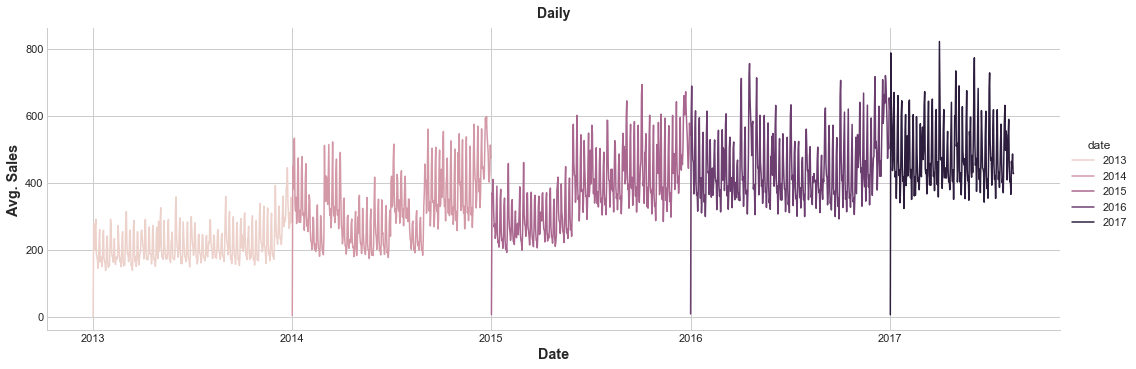

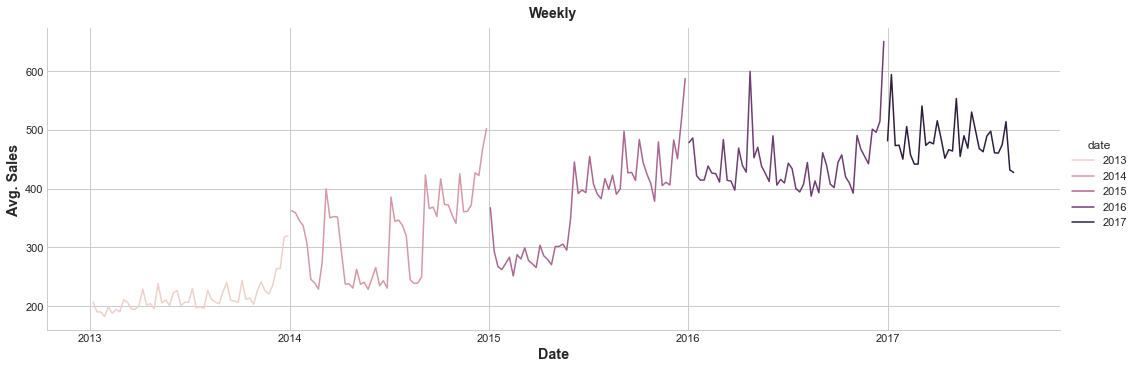

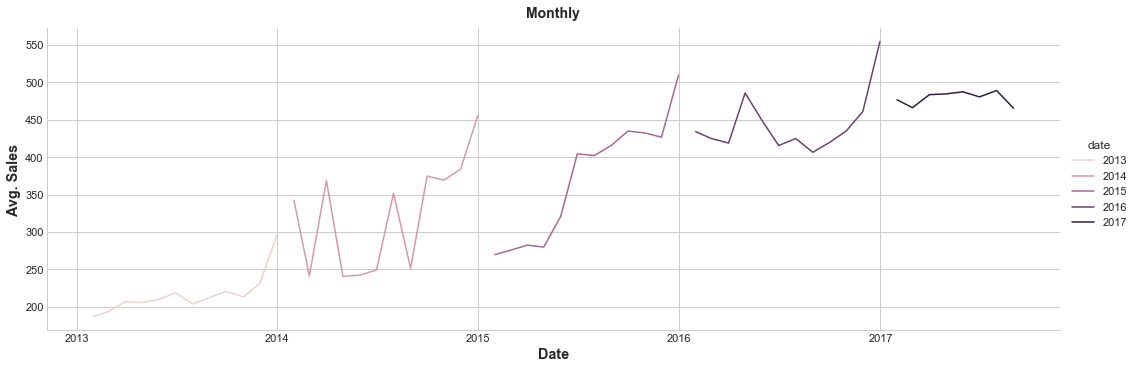

In [12]:

for sale, label in zip(dfs, lbls):
    sns.relplot(x=sale.index, y=sale.sales, kind='line', aspect=3, hue=sale.index.year)
    plt.xlabel('Date')
    plt.ylabel('Avg. Sales')
    plt.title(label)
plt.show()



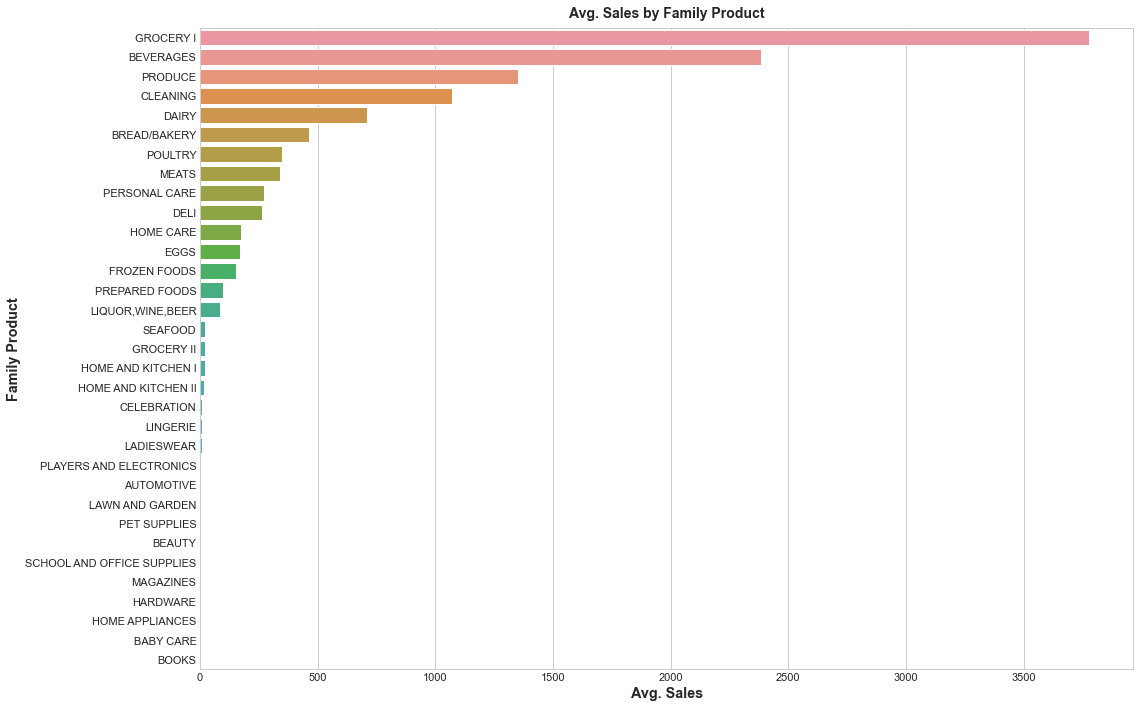

Top 5 Families:  ['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY']
Bottom 5 Families:  ['MAGAZINES', 'HARDWARE', 'HOME APPLIANCES', 'BABY CARE', 'BOOKS']


In [17]:
avg_sale_by_fam = train_view.groupby('family')['sales'].mean().sort_values(ascending=False).to_frame()
plt.figure(figsize=(16,10))
sns.barplot(data=avg_sale_by_fam,x=avg_sale_by_fam.sales,y=avg_sale_by_fam.index,ci=None,order=list(avg_sale_by_fam.index))
plt.xlabel('Avg. Sales')
plt.ylabel('Family Product')
plt.title('Avg. Sales by Family Product')
plt.show()

print("Top 5 Families: ", list(avg_sale_by_fam.index[:5]))
print("Bottom 5 Families: ", list(avg_sale_by_fam.index[-5:]))


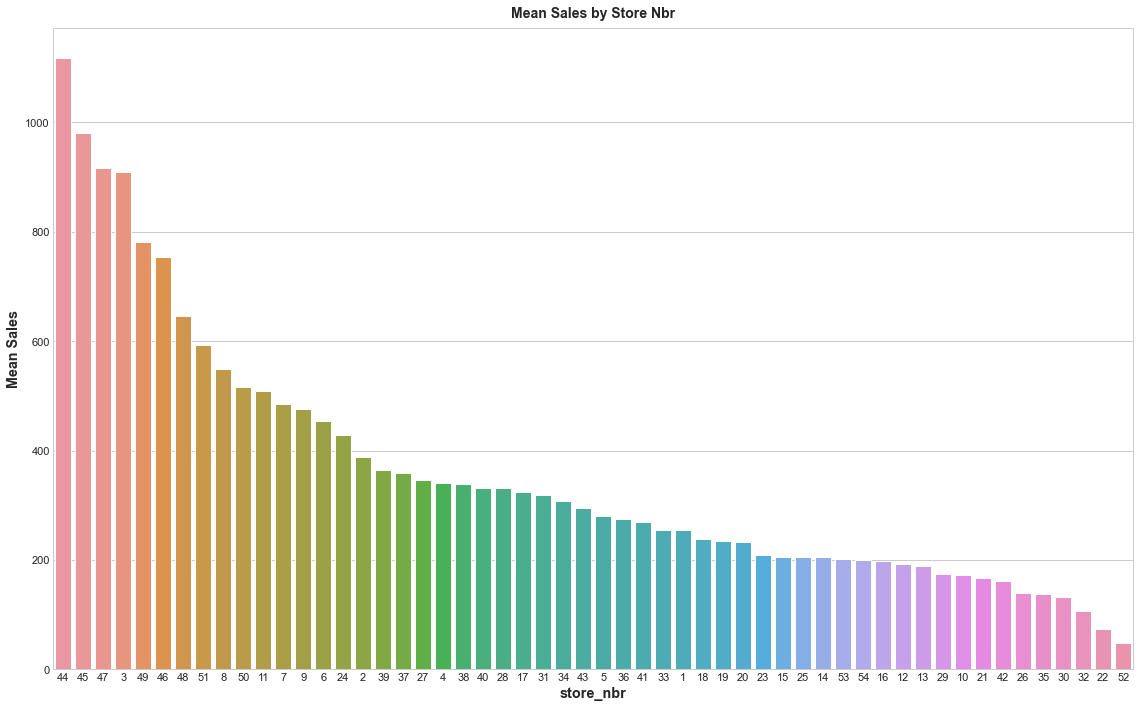

Top 5 Stores:  [44, 45, 47, 3, 49]
Bottom 5 Stores:  [35, 30, 32, 22, 52]


In [18]:
avg_sale_by_strnbr = train_view.groupby('store_nbr')['sales'].mean().sort_values(ascending=False).to_frame()
plt.figure(figsize=(16,10))
sns.barplot(data=avg_sale_by_strnbr,x=avg_sale_by_strnbr.index,y=avg_sale_by_strnbr.sales,ci=None,order=list(avg_sale_by_strnbr.index))
plt.xlabel('store_nbr')
plt.ylabel('Mean Sales')
plt.title('Mean Sales by Store Nbr')
plt.show()


print("Top 5 Stores: ", list(avg_sale_by_strnbr.index[:5]))
print("Bottom 5 Stores: ", list(avg_sale_by_strnbr.index[-5:]))


<AxesSubplot:title={'center':'Seasonal Plot (yearly/day_of_year)'}, xlabel='day_of_year', ylabel='sales'>

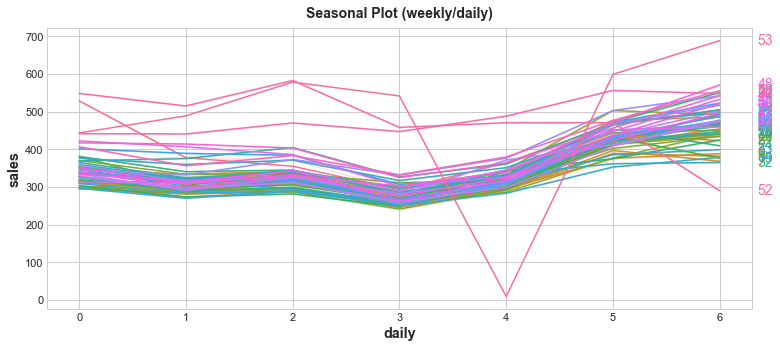

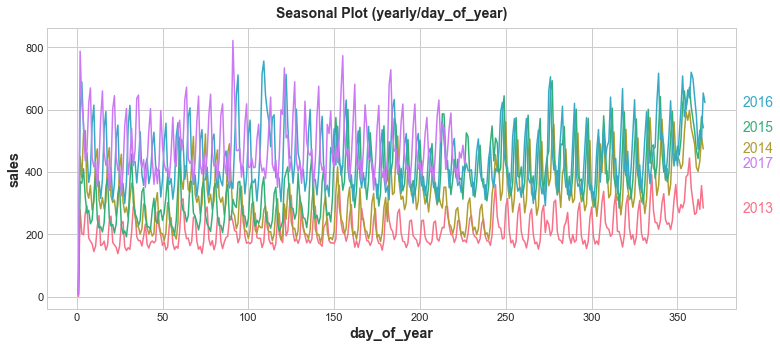

In [23]:
avg_sales = train_view.groupby('date')['sales'].mean().to_frame()
avg_sales['daily'] = avg_sales.index.dayofweek
avg_sales['weekly'] = avg_sales.index.week
avg_sales['day_of_year'] = avg_sales.index.dayofyear
avg_sales['yearly'] = avg_sales.index.year

seasonal_plot(avg_sales, y=avg_sales['sales'], period='weekly', freq='daily')
seasonal_plot(avg_sales, y=avg_sales['sales'], period='yearly', freq='day_of_year')


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

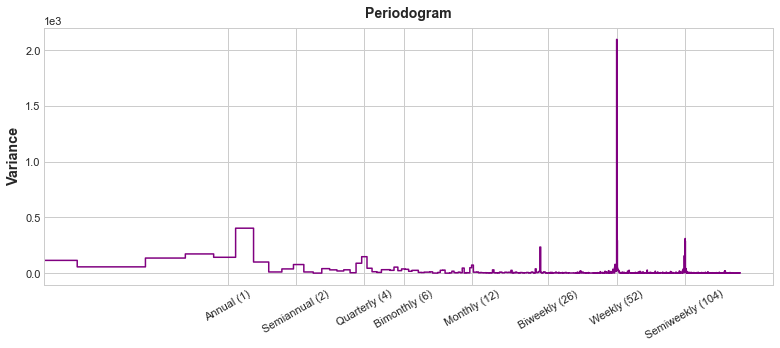

In [24]:
plot_periodogram(avg_sales.sales)

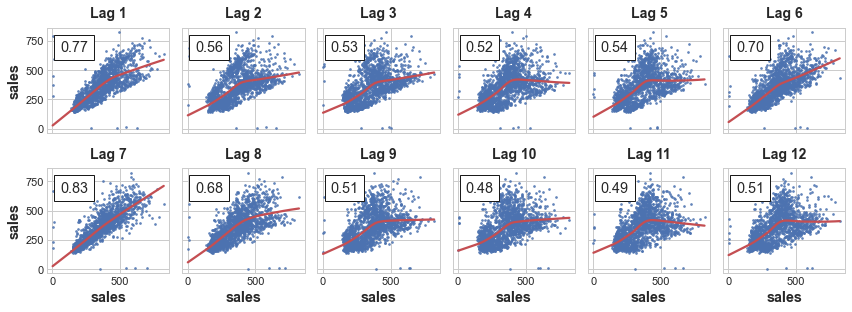

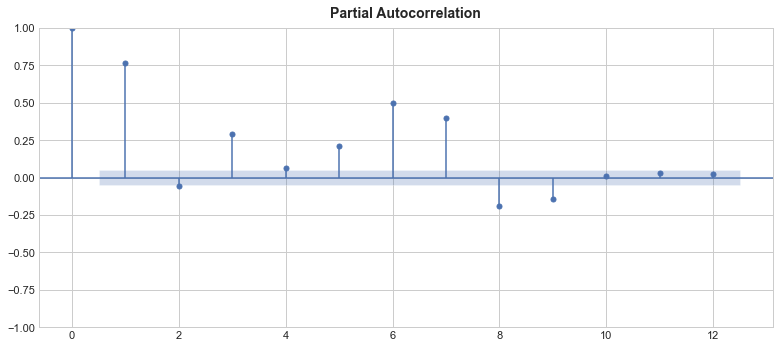

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_lags(avg_sales.sales, lags=12, nrows=2)
_ = plot_pacf(avg_sales.sales, lags=12)

Below we examine Oil Correlation

In [45]:
stores = df_data['store_load'].copy()
uniq = stores.city.value_counts()[stores.city.value_counts() == 1].index.tolist()
stores['uniq_store'] = stores.city.apply(lambda x: 1 if x in uniq else 0)
###WHY
new_stores = [19, 20, 21, 28, 35, 41, 51, 52]
stores['new_store'] = stores['store_nbr'].apply(lambda x: 1 if x in new_stores else 0)
stores = stores.rename(columns={'type': 'store'})
stores = stores.set_index('store_nbr')
df_data['str_mod'] = stores

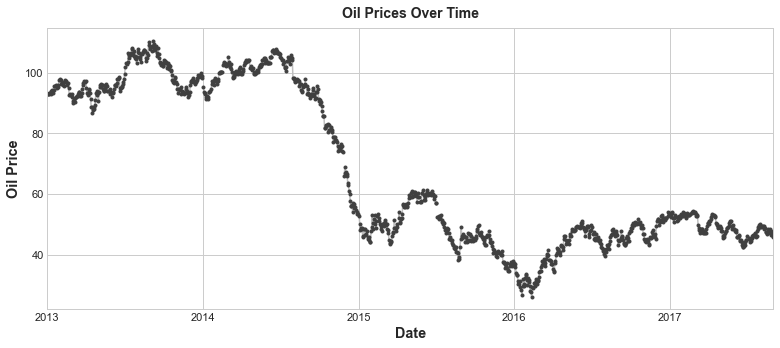

In [64]:
oil_view = df_data['oil_load'].copy()
oil_view.index = oil_view.index.to_timestamp()
oil_view.plot(**plot_params)
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.title('Oil Prices Over Time')
plt.show()

In [65]:
train_view = pd.merge(left=train_view, right=oil_view, left_index=True, right_index=True, how='left')
train_view['dcoilwtico'] = train_view['dcoilwtico'].fillna(method='ffill').fillna(method='bfill').astype('float16')

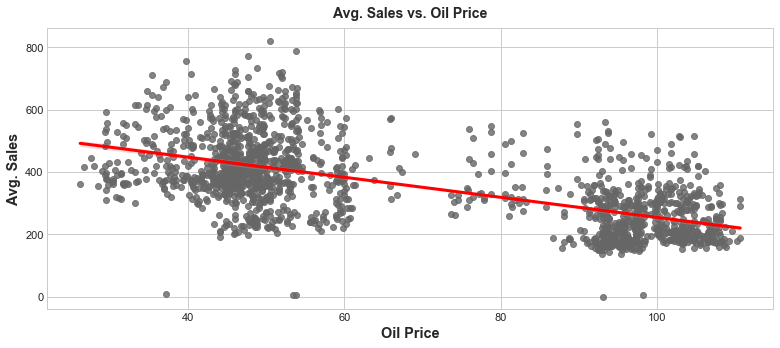

In [66]:
avg_oil_sales = train_view.groupby(['date', 'dcoilwtico'])['sales'].mean().reset_index()

sns.regplot(data=avg_oil_sales, x='dcoilwtico', y='sales', scatter_kws={'color':'0.4'},
            line_kws={'color':'red', 'linewidth':3})
plt.xlabel('Oil Price')
plt.ylabel('Avg. Sales')
plt.title('Avg. Sales vs. Oil Price')
plt.show()

In [28]:
oil = df_data['oil_load'].copy()
oil = oil.resample('D').mean().interpolate(limit_direction='backward').reset_index()
oil = lag_feature(oil, 'dcoilwtico', [1, 2, 3, 4], drop=False)
oil['wk_avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
oil['biwk_avg_oil'] = oil['dcoilwtico'].rolling(14).mean()
oil['mnth_avg_oil'] = oil['dcoilwtico'].rolling(30).mean()
oil['bimnth_avg_oil'] = oil['dcoilwtico'].rolling(60).mean()
oil.dropna(inplace=True)
oil = oil.set_index('date')
df_data['oil_mod'] = oil

In [46]:
date_range = pd.Series(pd.date_range('2013-01-01', '2017-08-31').to_period('D'), name='date')
cal = pd.DataFrame(index=date_range)
cal = cal.merge(df_data['holiday_load'], how='left', on=['date'])
cal.loc[cal.isna().any(axis=1),
           ['type', 'locale', 'locale_name', 'transferred']] = 'Work Day', 'National', 'Ecuador', False
cal['wd'] = True
cal.loc[(cal.type == 'Bridge') | (cal.type == 'Transfer'), 'wd'] = False

cal.loc[(((cal.type == 'Additional')|(cal.type == 'Holiday')) & (cal.transferred == False)), 'wd'] = False
easter = ['2017-04-16', '2016-03-27', '2015-04-05', '2014-04-20', '2013-03-31']
easter = [pd.to_datetime(date, format='%Y-%m-%d').to_period('D') for date in easter]
cal['isevnt'] = False
cal.loc[cal.index.get_level_values('date').isin(easter), 'isevnt'] = True
cal = pd.get_dummies(cal, columns=['type'])
cal = pd.get_dummies(cal, columns=['locale'])
cal.drop(columns=['locale_name', 'transferred'], inplace=True)
agg=lambda x: np.bitwise_or.reduce(x.values)
cal = cal.groupby('date').agg(agg)
df_data['cal'] = cal

In [47]:
train_df = df_data['train_load'].copy()
test_df = df_data['test_load'].copy()
test_df.sales = np.nan

df = pd.concat([train_df, test_df], axis=0)
df = df.merge(df_data['str_mod'], how='left', left_index=True, right_index=True)
df.drop(df.filter(regex='_y$').columns, axis=1, inplace=True)
df['closed'] = df.groupby(by=['date', 'store_nbr'])['sales'].transform(lambda x:1 if x.sum() ==0 else 0)
# stores in test set aren't close, just have 0 sales
df.loc[
    ((df.index.get_level_values('date').year==2017) &
     (df.index.get_level_values('date').month==8) & (
             df.index.get_level_values('date').day>=16)) , 'closed'] = df['closed'].apply(lambda x: 0)

## Holidays
df = df.merge(df_data['cal'], how='left', left_index=True, right_index=True, suffixes=('', '_y'))
df.drop(df.filter(regex='_y$').columns, axis=1, inplace=True)

In [48]:
## Oil
df = df.merge(df_data['oil_mod'], how='left', left_index=True, right_index=True)

In [50]:
df_data['fmerge'] = df.copy()

In [14]:
df['year'] = df.index.get_level_values('date').year.astype('int')
df['quarter'] = df.index.get_level_values('date').quarter.astype('int')
df['day'] = df.index.get_level_values('date').day.astype('int')

df['weekofyear'] = df.index.get_level_values('date').week.astype('int')
df['dayofweek'] = df.index.get_level_values('date').day_of_week.astype('int')
df['isweekend'] = df.dayofweek.apply(lambda x: 1 if x in (5,6) else 0)

df['newyear'] = df.index.get_level_values('date').dayofyear == 1
df['startschool'] = df.index.get_level_values('date').month.isin((4,5,8,9))
df['weekend'] = df.index.get_level_values('date').dayofweek.isin((5,6))

In [15]:
df['payday'] = ((df.index.get_level_values('date').to_timestamp().is_month_end) | (df.index.get_level_values('date').day == 15))

quake_dates = [d.to_period('D') for d in pd.date_range('2016-04-16', periods=20, freq='D').tolist()]
df['quake'] = df.index.get_level_values('date').isin(quake_dates)

In [16]:
df = pd.get_dummies(df, columns=['year'], drop_first=True)
df = pd.get_dummies(df, columns=['quarter'], drop_first=True)
df = pd.get_dummies(df, columns=['dayofweek'], drop_first=True)

df['wk_avg_promo'] = df['onpromotion'].rolling(7).mean()
df['biwk_avh_promo'] = df['onpromotion'].rolling(14).mean()
df['mnth_avg_promo'] = df['onpromotion'].rolling(30).mean()
df['bimnth_avg_promo'] = df['onpromotion'].rolling(60).mean()

df.drop(columns=['city', 'cluster', 'state', 'store'], inplace=True)

In [19]:
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier

fourier_annual = CalendarFourier(freq='A', order=5)
fourier_monthly = CalendarFourier(freq='M', order=2)
fourier_weekly = CalendarFourier(freq='W', order=3)

terms = [fourier_annual, fourier_monthly, fourier_weekly]

dp = DeterministicProcess(index=df.index.get_level_values('date'),
                          order=1,
                          seasonal=True,
                          constant=False,
                          additional_terms=terms,
                          drop=True)

df_dp = dp.in_sample()
df = pd.concat([df.reset_index(level=['store_nbr', 'family']), df_dp], axis=1)

df = df.set_index(['store_nbr', 'family'], append=True)